In [1]:
#basic libraries
import h2o
import numpy as np
import pandas as pd
import re

#scikit-learn libraries
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

#h2o models and grid search
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Model Training
After finishing the data preprocessing and imputation, I will train the model. I will use 3 algorithms to compare the result, and use the top 2 as baseline models. The algorithms are gradient boosting, deep learning, and XGBoost. For the first 2 algorithms, I will use the H2O library. For the XGBoost algorithm, I will use the XGBoost library since it is not supported in the current version of H2O (I'm using windows). In the next notebook, I will perform feature engineering to add features to the dataset, hopefully making the model better. If the model is not better, I will use the best of the baseline models to create a prediction pipeline.

In [2]:
#reading the final dataset
df_use = pd.read_csv('final_data.csv')

In [3]:
#initializing H2O. Reminder: H2O needs java.
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Users\agust\Anaconda3\envs\h2o_loan_classification\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\agust\AppData\Local\Temp\tmp79sj04_u
  JVM stdout: C:\Users\agust\AppData\Local\Temp\tmp79sj04_u\h2o_agust_started_from_python.out
  JVM stderr: C:\Users\agust\AppData\Local\Temp\tmp79sj04_u\h2o_agust_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Jakarta
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_agust_x8uhqv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.854 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [4]:
#parsing the dataframe to H2O dataframe
hf = h2o.H2OFrame(df_use)

#separating predictors and response
predictors = list(df_use.columns[1:])
response = "loan_status"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
#create train, test, and validation dataset
train_temp, test = hf.split_frame(ratios = [.8], seed = 42)
train, val = train_temp.split_frame(ratios = [.8], seed = 42)

## Using Gradient Boosting Model
For this part, I will use H2OGridSearch combined with H2OGradientBoostingEstimator to train the model. I will set the hyperparameters to tune first, initialize the grid search, and train the model. For the model training phase, I will use the validation dataset instead of the testing dataset. Next, I will select the best model out of the results and use it to evaluate the model performance on the test dataset. Lastly, I will create a feature importance plot to examine which feature contributes to the model the most.

In [6]:
#hyperparameters to tune
gbm_params1 = {'learn_rate': [0.01, 0.05, 0.1],
                'max_depth': [5, 7, 9],
                'ntrees': [300, 500, 700],
                'sample_rate': [0.5, 0.8, 1.0],
                'col_sample_rate': [0.25, 0.5, 1.0]}

#initializing grid search
gbm_grid1 = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id='gbm_grid1',
    hyper_params=gbm_params1
)

In [7]:
#model training
gbm_grid1.train(
    x=predictors,
    y=response,
    training_frame=train,
    validation_frame=val,  # Include your validation frame here
    seed=42
)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,logloss
,1.0,0.01,9.0,700.0,0.8,gbm_grid1_model_156,0.5416276
,0.5,0.01,9.0,700.0,0.8,gbm_grid1_model_155,0.5419503
,1.0,0.01,9.0,500.0,0.8,gbm_grid1_model_129,0.5421302
,0.5,0.05,7.0,300.0,1.0,gbm_grid1_model_176,0.5423889
,1.0,0.05,5.0,300.0,1.0,gbm_grid1_model_168,0.5424562
,0.5,0.01,7.0,700.0,1.0,gbm_grid1_model_227,0.5424758
,0.5,0.01,9.0,700.0,1.0,gbm_grid1_model_236,0.5425033
,0.5,0.01,9.0,500.0,0.8,gbm_grid1_model_128,0.5426462
,1.0,0.05,5.0,500.0,0.8,gbm_grid1_model_114,0.5427060
,1.0,0.05,5.0,700.0,0.8,gbm_grid1_model_141,0.5427060


In [8]:
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='aucpr', decreasing=True)
gbm_gridperf1

,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,aucpr
,0.25,0.01,9.0,700.0,0.8,gbm_grid1_model_154,0.4908916
,0.5,0.01,9.0,700.0,0.8,gbm_grid1_model_155,0.4905253
,0.5,0.01,7.0,700.0,1.0,gbm_grid1_model_227,0.4904542
,0.5,0.01,9.0,500.0,0.8,gbm_grid1_model_128,0.4895133
,1.0,0.05,5.0,300.0,1.0,gbm_grid1_model_168,0.4894263
,0.25,0.05,7.0,500.0,1.0,gbm_grid1_model_202,0.4892838
,0.25,0.05,7.0,700.0,1.0,gbm_grid1_model_229,0.4892838
,1.0,0.01,7.0,700.0,0.5,gbm_grid1_model_66,0.4889319
,1.0,0.01,9.0,700.0,0.8,gbm_grid1_model_156,0.4889265
,1.0,0.05,5.0,700.0,0.5,gbm_grid1_model_60,0.4889039


In [9]:
#get the best model
best_gbm1 = gbm_gridperf1.models[0]

#evaluate the model against the test data
perf = best_gbm1.model_performance(test)
print(perf)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.18217842565624304
RMSE: 0.42682364702092485
LogLoss: 0.5436652495002108
Mean Per-Class Error: 0.3707760370083102
AUC: 0.692562817328524
AUCPR: 0.47959687988212923
Gini: 0.38512563465704797

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24279204886962436
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    6439          6340            0.4961   (6340.0/12779.0)
loan_refused  1234          3794            0.2454   (1234.0/5028.0)
Total         7673          10134           0.4253   (7574.0/17807.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.242792     0.500462  258
max f2                       0.138046     0.677676  340
max f0point5                 0.381356     0.46

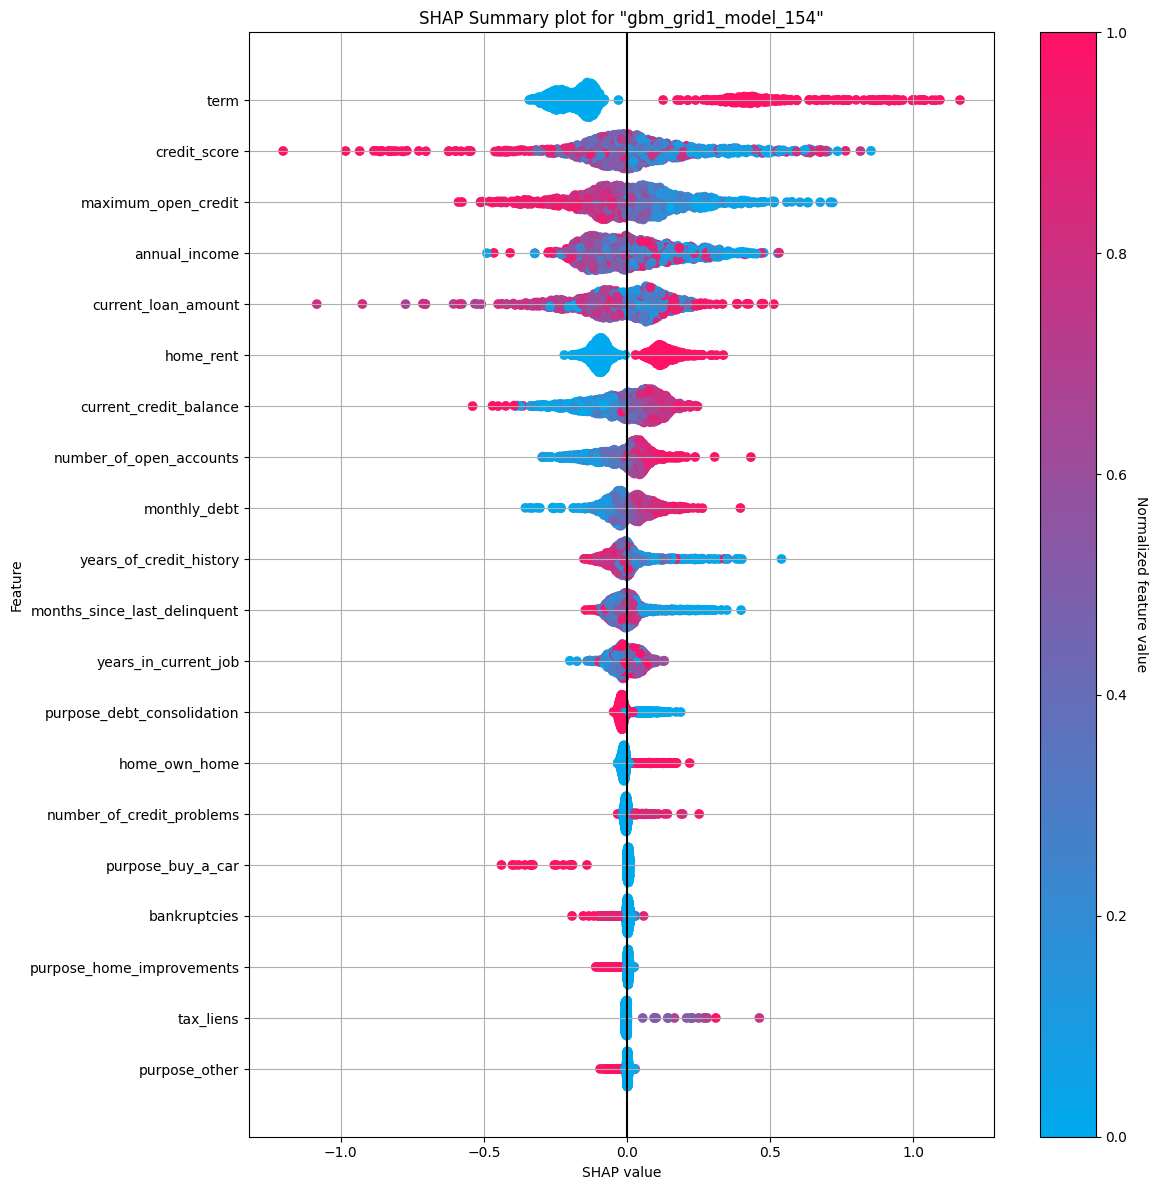

In [10]:
best_gbm1.shap_summary_plot(test)

In [11]:
# Get the variable importance scores
varimp_gbm = best_gbm1.varimp()

In [12]:
def plot_feature_importance(feature_importance_list):
    features = [item[0] for item in feature_importance_list]
    importance_scores = [item[1] for item in feature_importance_list]

    plt.figure(figsize=(10, 6))
    plt.barh(features, importance_scores, color='skyblue')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show();

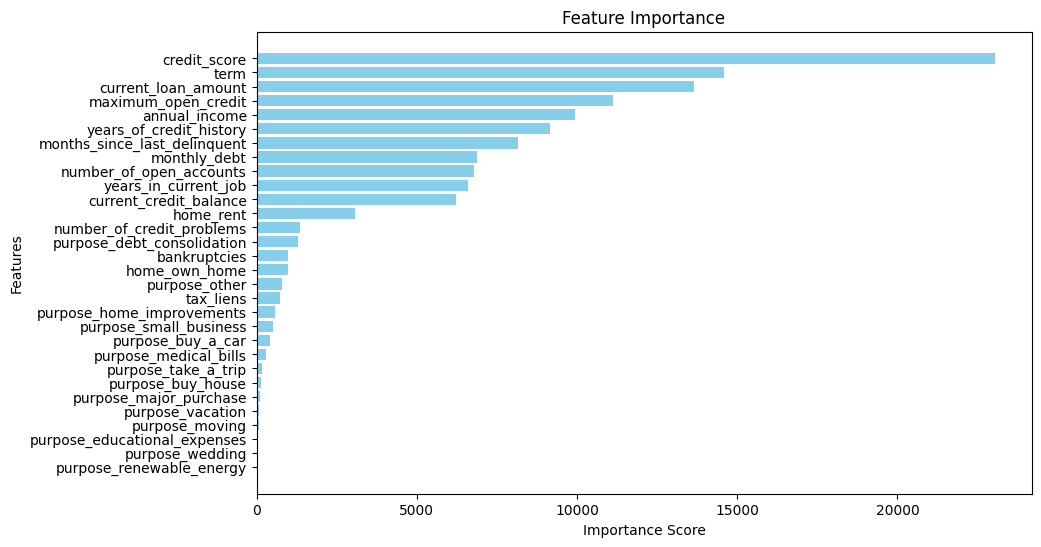

In [13]:
#plot the feature importance
plot_feature_importance(varimp_gbm)

In [14]:
#saving model
model_path = h2o.save_model(
  best_gbm1,
  path = "model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'C:\\Online Course\\Projects\\loan-classification-h20-xgboost\\model\\gbm_grid1_model_154'

# Using Deep Learning
For this part, I will use H2OGridSearch combined with H2ODeepLearningEstimator to train the model. I will set the hyperparameters to tune first, initialize the grid search, and train the model. For the model training phase, I will use the validation dataset instead of the testing dataset. Next, I will select the best model out of the results and use it to evaluate the model performance on the test dataset. Lastly, I will create a feature importance plot to examine which feature contributes to the model the most.

In [15]:
#hyperparameters to tune
hyper_params = {
    'hidden': [[16, 16], [16, 32, 64], [16, 32, 64, 128]],
    'epochs': [50, 100, 200],
    'balance_classes': [True, False],
    'activation': ['Rectifier', 'Tanh', 'RectifierWithDropout','Maxout']
}

#initialize grid search
dl_grid = H2OGridSearch(
    model=H2ODeepLearningEstimator,
    grid_id='dl_grid',
    hyper_params=hyper_params
)

In [16]:
#train the model
dl_grid.train(
    x=predictors,
    y=response,
    training_frame=train,
    validation_frame=val
)

deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


,activation,balance_classes,epochs,hidden,model_ids,logloss
,Rectifier,false,200.0,"[16, 32, 64, 128]",dl_grid_model_69,0.5542088
,Tanh,false,200.0,"[16, 32, 64]",dl_grid_model_46,0.5547078
,Rectifier,true,200.0,"[16, 16]",dl_grid_model_17,0.5548579
,Tanh,true,50.0,"[16, 32, 64, 128]",dl_grid_model_50,0.5556024
,Rectifier,false,100.0,"[16, 32, 64, 128]",dl_grid_model_61,0.5557879
,Tanh,true,200.0,"[16, 32, 64, 128]",dl_grid_model_66,0.5560786
,Maxout,false,100.0,"[16, 32, 64]",dl_grid_model_40,0.5561367
,Tanh,true,100.0,"[16, 32, 64, 128]",dl_grid_model_58,0.5562016
,Rectifier,false,50.0,"[16, 32, 64, 128]",dl_grid_model_53,0.5562515
,Rectifier,false,50.0,"[16, 32, 64]",dl_grid_model_29,0.5564765


In [17]:
# Get the best model from the grid search
best_dl_model = dl_grid.get_grid()[0]

#evaluate model performance against the test data
perf = best_dl_model.model_performance(test)
print(perf)

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18654731826646476
RMSE: 0.431911238874916
LogLoss: 0.5564986474382391
Mean Per-Class Error: 0.384503187191247
AUC: 0.6711912079427745
AUCPR: 0.4586857357714456
Gini: 0.3423824158855491

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24406734255546753
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    5956          6823            0.5339   (6823.0/12779.0)
loan_refused  1182          3846            0.2351   (1182.0/5028.0)
Total         7138          10669           0.4495   (8005.0/17807.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244067     0.49003   268
max f2                       0.130286     0.669182  346
max f0point5                 0.396569    

In [ ]:
#get feature importance score and plot it
varimp_dl = best_dl_model.varimp()
plot_feature_importance(varimp_dl)

# Using XGBoost
For this part, I will use GridSearchCV from scikit-learn combined with XGBoostClassifier to train the model. I will set the hyperparameters to tune first, initialize the grid search, and train the model. For the model training phase, I will use the validation dataset instead of the testing dataset. Next, I will select the best model out of the results and use it to evaluate the model performance on the test dataset. Lastly, I will create a feature importance plot to examine which feature contributes to the model the most. Since there are no built-in methods to plot the feature importance, I will use the SHAP library to do that.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib
import shap
import pandas as pd
import numpy as np
%matplotlib inline

In [ ]:
#reading the final dataset
df_use = pd.read_csv('final_data.csv')

#separate predictors and target
X = df_use.drop('loan_status', axis=1)
y = pd.DataFrame(df_use['loan_status'])

#mapping the target variable to 0 and 1 so that the algorithm works
mapping = {
    'loan_refused': 0,
    'loan_given': 1
}
y['loan_status'] = y['loan_status'].map(mapping)

#split the dataset into train, test, and validation
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

print(f'The number of training dataset is {X_train.shape[0]}, the number of validation dataset is {X_val.shape[0]}, and the number of testing dataset is {X_test.shape[0]}.')

In [ ]:
#hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'learning_rate': [0.1, 0.01],
    'max_bin': [128, 256, 512]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=42, eval_metric='auc', early_stopping_rounds=10)

# Initialize GridSearchCV with the XGBoost classifier and parameter grid
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train,eval_set=[(X_val, y_val)], verbose = 0)

In [ ]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_auc = best_model.score(X_test, y_test)
print("Test AUC Score:", test_auc)

### XGBoost Model Explanation
Since there is no built-in method to explain this model, I will use the shap library to do so. Similar to the previous 2 models, I will use the shap summary plot and bar plot to explain the model.

In [ ]:
import shap

In [ ]:
shap_values = explainer(X_val)

#shap summary plot
shap.summary_plot(shap_values, X_val)

The key takeaways from the plot above:
1. The top 3 features of this model is term, credit score, and maximum_open_credit.
2. Begining on the purpose_debt_consolidation to purpose_home_improvements, these features don't affect the prediction much, since the examples are mostly located around 0.
3. When the loans are long term, it makes the model predicts the application as not given (loan_refused). Whereas when the loans are short term, it makes the model predicts the application as given (loan_given).
4. Higher credit score is also associated with the model predicts the loan application to be given, although there are obvious examples that people with higher credit score also get their loans rejected as well. 
5. Higher maximum open credit is also associated with the model predicts the loan application to be given.

In [ ]:
#bar chart for shap values
shap.plots.bar(shap_values)

The bar plot also shows the most important features and how they affect the model.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# evaluate the model on the test dataset
y_pred = best_model.predict(X_test)

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

class_names = ['loan_refused', 'loan_given']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Actual vs Predicted)')
plt.show();

Based on the confusion matrix, I think the model correctly predicts when the loan is given when it's supposed to be given. However, it does a pretty poor job in predicting when the loan is refused when it's supposed to be refused.

After examining the result, based on the AUC score, the models that I'm going to use as the base models are the gradient boosting model and the XGBoost model. 

In the next notebook, I'm going to add features to the dataset to try to increase the performances of the models.

In [ ]:
#saving the model
import joblib

joblib.dump(best_model, 'model/best_xgb_model.pkl')